<a href="https://colab.research.google.com/github/Abiben100/Housing-Price-prediction/blob/main/Quantile_Regression_Housing_P_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import necessary Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.regression.quantile_regression import QuantReg
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
# Load the dataset
file_path = '/content/drive/My Drive/HousingPricePrediction/Housing.csv'
housing_data = pd.read_csv(file_path)

In [ ]:
# Convert 'yes'/'no' columns to numeric (1/0)
for col in housing_data.columns:
    if housing_data[col].dtype == 'object' and housing_data[col].nunique() <= 2:
        housing_data[col] = housing_data[col].map({'yes': 1, 'no': 0})

# Map 'furnishingstatus' column into 1, 2, 3 depending on the status
furnishing_mapping = {'furnished': 3, 'semi-furnished': 2, 'unfurnished': 1}
housing_data['furnishingstatus'] = housing_data['furnishingstatus'].map(furnishing_mapping)

In [ ]:
# Handle missing values for numerical columns by filling with the column mean
housing_data.fillna(housing_data.mean(), inplace=True)

# Log-transform the target variable 'price'
housing_data['log_price'] = np.log(housing_data['price'])

In [ ]:
# Feature Engineering: Combine 'bedrooms' and 'bathrooms' into 'rooms_combined'
housing_data['rooms_combined'] = housing_data['bedrooms'] + housing_data['bathrooms']

In [ ]:
# Apply non-linear transformations to predictor variables
housing_data['sqrt_area'] = np.sqrt(housing_data['area'])  # Square root transformation
housing_data['log_area'] = np.log1p(housing_data['area'])  # Logarithmic transformation
housing_data['sqrt_rooms_combined'] = np.sqrt(housing_data['rooms_combined'])  # Square root


In [ ]:
# Drop the original 'bedrooms', 'bathrooms', and other redundant columns
housing_data.drop(['bedrooms', 'bathrooms', 'area', 'rooms_combined'], axis=1, inplace=True)

In [ ]:
# --- Outlier Removal Using IQR ---
# Define a function to remove outliers based on IQR
def remove_outliers_iqr(data, columns):
    for col in columns:
        Q1 = data[col].quantile(0.25)  # First quartile (25th percentile)
        Q3 = data[col].quantile(0.75)  # Third quartile (75th percentile)
        IQR = Q3 - Q1  # Interquartile range
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        data = data[(data[col] >= lower_bound) & (data[col] <= upper_bound)]
    return data

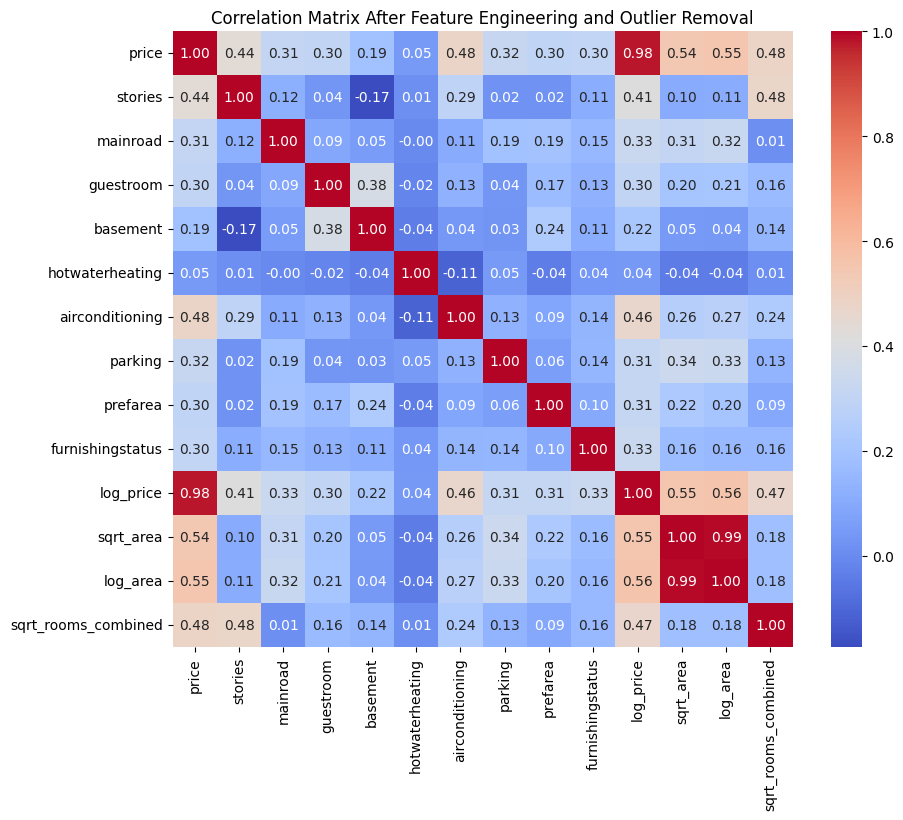

In [ ]:
# Apply the function to the numerical columns
numerical_columns = ['price', 'log_price', 'sqrt_area', 'log_area', 'sqrt_rooms_combined']
housing_data = remove_outliers_iqr(housing_data, numerical_columns)

# Visualize the correlation matrix after feature engineering and outlier removal
correlation_matrix = housing_data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix After Feature Engineering and Outlier Removal")
plt.show()


Quantile: 0.25
                         QuantReg Regression Results                          
Dep. Variable:              log_price   Pseudo R-squared:               0.3936
Model:                       QuantReg   Bandwidth:                      0.1143
Method:                 Least Squares   Sparsity:                       0.5990
Date:                Mon, 06 Jan 2025   No. Observations:                  411
Time:                        00:40:41   Df Residuals:                      399
                                        Df Model:                           12
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
stories                 0.0714      0.017      4.116      0.000       0.037       0.105
mainroad                0.0563      0.041      1.358      0.175      -0.025       0.138
guestroom              -0.0174      0.037     -0.473      0.637      -0.090    

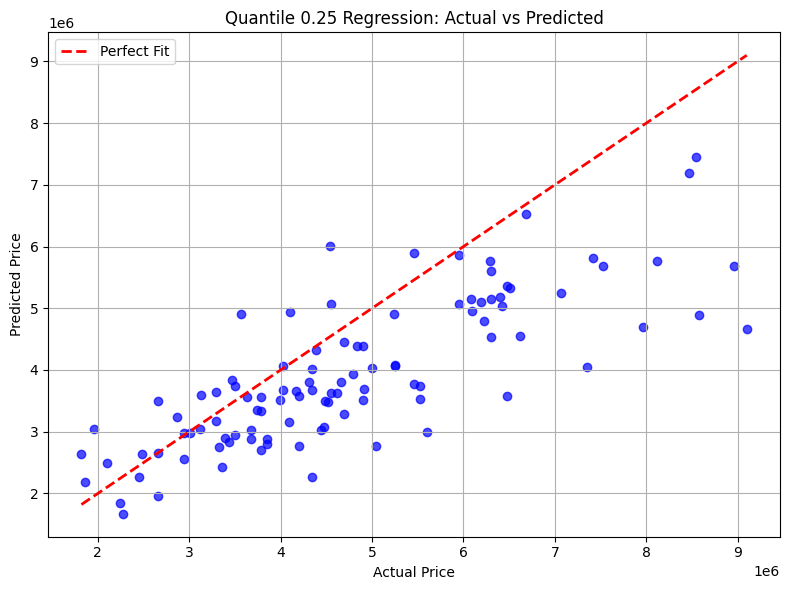


Quantile: 0.5
                         QuantReg Regression Results                          
Dep. Variable:              log_price   Pseudo R-squared:               0.4277
Model:                       QuantReg   Bandwidth:                      0.1214
Method:                 Least Squares   Sparsity:                       0.4542
Date:                Mon, 06 Jan 2025   No. Observations:                  411
Time:                        00:40:42   Df Residuals:                      399
                                        Df Model:                           12
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
stories                 0.0909      0.016      5.689      0.000       0.059       0.122
mainroad                0.0844      0.035      2.433      0.015       0.016       0.153
guestroom               0.0207      0.033      0.631      0.529      -0.044     

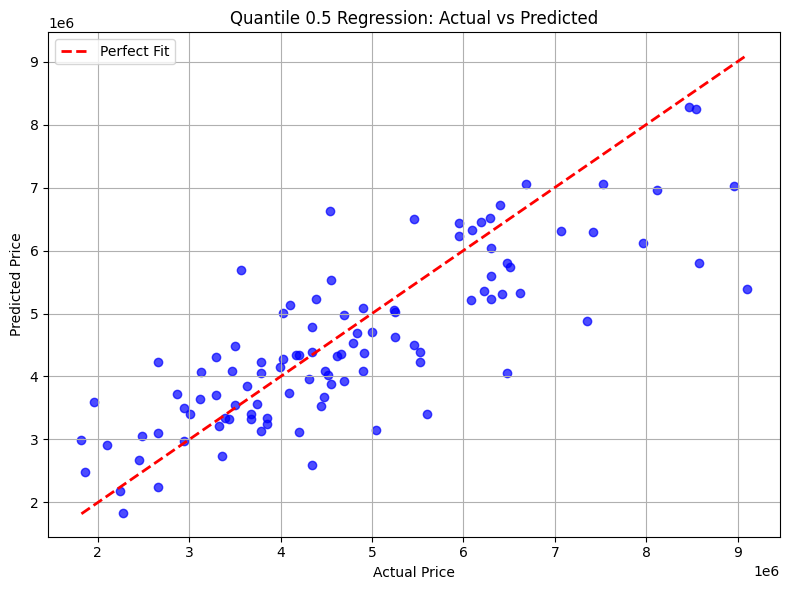


Quantile: 0.75
                         QuantReg Regression Results                          
Dep. Variable:              log_price   Pseudo R-squared:               0.4328
Model:                       QuantReg   Bandwidth:                      0.1094
Method:                 Least Squares   Sparsity:                       0.5390
Date:                Mon, 06 Jan 2025   No. Observations:                  411
Time:                        00:40:42   Df Residuals:                      399
                                        Df Model:                           12
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
stories                 0.0899      0.017      5.236      0.000       0.056       0.124
mainroad                0.0256      0.035      0.732      0.465      -0.043       0.094
guestroom               0.0349      0.035      0.999      0.319      -0.034    

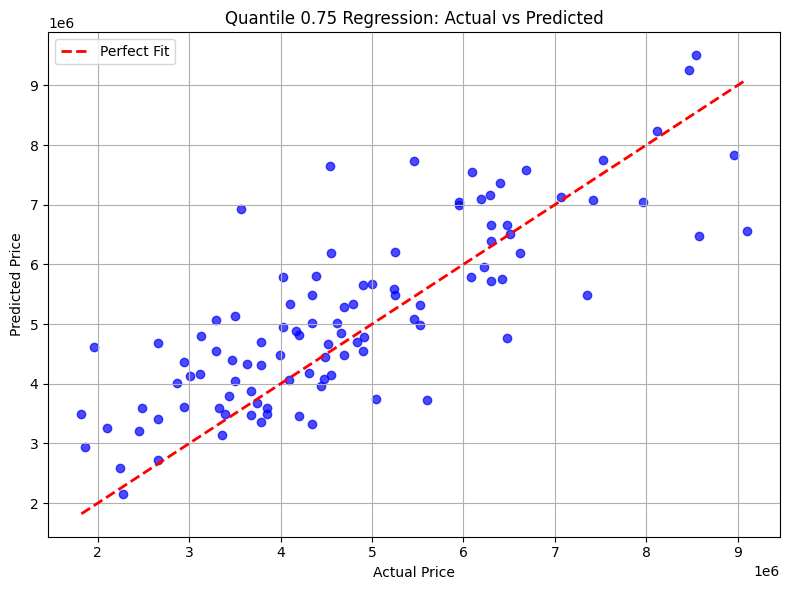

In [ ]:
# Define features (X) and target variable (y)
X = housing_data.drop(['price', 'log_price'], axis=1)
y = housing_data['log_price']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Quantile Regression ---
quantiles = [0.25, 0.5, 0.75]  # Specify quantiles for analysis

# Train and evaluate Quantile Regression models for each quantile
for q in quantiles:
    model_qr = QuantReg(y_train, X_train)
    result = model_qr.fit(q=q)

    # Make predictions on the test set
    y_pred_q = result.predict(X_test)

    # Evaluate the model on the log-transformed scale
    mse_log = mean_squared_error(y_test, y_pred_q)
    r2_log = r2_score(y_test, y_pred_q)

    # Convert predictions back to the original scale
    y_pred_original = np.exp(y_pred_q)
    mse_original = mean_squared_error(np.exp(y_test), y_pred_original)
    r2_original = r2_score(np.exp(y_test), y_pred_original)

    # Print metrics for Log-Transformed and Original Price
    print(f"\nQuantile: {q}")
    print(result.summary())  # Display summary of the regression for the quantile
    print(f"Log-Transformed MSE for Quantile {q}: {mse_log}")
    print(f"Log-Transformed R2 for Quantile {q}: {r2_log}")
    print(f"Original Scale MSE for Quantile {q}: {mse_original}")
    print(f"Original Scale R2 for Quantile {q}: {r2_original}")

    # Plot Actual vs. Predicted Values for original price
    plt.figure(figsize=(8, 6))
    plt.scatter(np.exp(y_test), y_pred_original, alpha=0.7, color='blue')
    plt.plot([np.exp(y_test).min(), np.exp(y_test).max()],
             [np.exp(y_test).min(), np.exp(y_test).max()],
             'r--', lw=2, label="Perfect Fit")
    plt.title(f'Quantile {q} Regression: Actual vs Predicted')
    plt.xlabel('Actual Price')
    plt.ylabel('Predicted Price')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

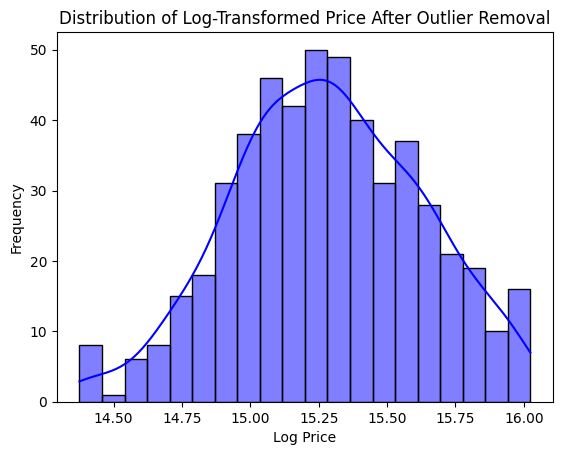

In [ ]:
# Visualize log-transformed price distribution
sns.histplot(housing_data['log_price'], kde=True, bins=20, color='blue')
plt.title('Distribution of Log-Transformed Price After Outlier Removal')
plt.xlabel('Log Price')
plt.ylabel('Frequency')
plt.show()

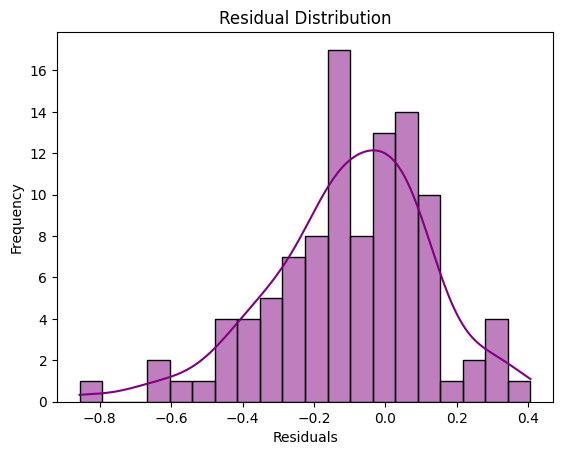

In [ ]:
# Residual Analysis
residuals = y_test - y_pred_q

# Residual Distribution
sns.histplot(residuals, kde=True, bins=20, color='purple')
plt.title("Residual Distribution")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()

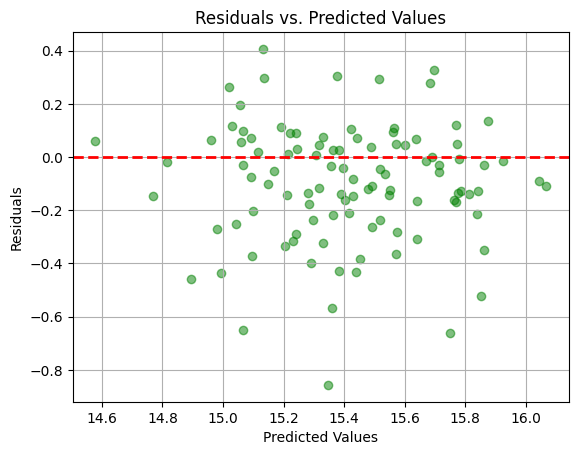

In [ ]:
# Residuals vs. Predicted Values
plt.scatter(y_pred_q, residuals, alpha=0.5, color='green')
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.title("Residuals vs. Predicted Values")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.grid(True)
plt.show()